In [110]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from plotly import express as px

abw = pd.read_csv(
    "~/user/Downloads/20220419_182858.csv", parse_dates=True
).rename(columns={"Abwasser Täglich": "daily", "__timestamp": "date"}).set_index("date").filter(("daily",)).loc["2021-03-15":]
abw.index = pd.to_datetime(abw.index)
abw.index = abw.index.strftime("%Y-%m-%d")

wet = pd.read_csv("Wetter_Dresden_seit2021.csv").set_index("date").filter(("prcp",))

# rki
rki = pd.read_csv("Dresden_RKI_data.csv").set_index("Refdatum")
rki.rename(columns={"rki_7tage": "rki_7days", "rki_14tage": "rki_14days", "rki_28tage": "rki_28days"}, inplace=True)

# join
df = abw.join(rki).join(wet)
df = df.dropna()
df.index = pd.to_datetime(df.index)
df = df.asfreq("D")

# handle precipitation
df[f"daily"] = df.loc[df.prcp < 5, f"daily"]
# df = df.interpolate("time", axis=0)
df["sum_7days"] = df["daily"].rolling(7, min_periods=1, closed="left").mean() * 7
df["sum_14days"] = df["daily"].rolling(14, min_periods=1, closed="left").mean() * 7
df["sum_28days"] = df["daily"].rolling(28, min_periods=1, closed="left").mean() * 7

# style = {f"rki_{k}days": "k--" for k in (7, 14, 28)}
# style.update({k: "r" for k in ("sum_7days", "sum_14days", "sum_28days", "daily")})
# df.plot(figsize=(20,6), secondary_y=("sum_7days", "sum_14days", "sum_28days", "daily"), style=style)
# plt.savefig("verlauf.png")
# plt.show()
px.line(df/df.max())
# px.line(df, log_y=True)
# variants


In [144]:
def get_lag(left, right, method="pearson"):
    rng = range(-12, 12)
    rs = [right.corr(left.shift(lag), method=method) for lag in rng]
    rs = pd.DataFrame(rs, index=rng)
    return rs.idxmax()[0]

def shift(df, day):
    lag = get_lag(df[f"rki_{day}days"], df[f"sum_{day}days"])
    df[f"rki_{day}days"] = df[f"rki_{day}days"].shift(lag)
    return df, lag

# Linear regression
def get_lin_model(left, right, v):
    c, i = get_lin_coeff(left, right, v)
    return left * c + i

def get_lin_coeff(left, right, v):
    X = left.to_numpy().reshape(-1, 1)
    y = right.to_numpy().reshape(-1, 1)
    reg = LinearRegression().fit(X, y, sample_weight=var[v].loc[left.index])
    return reg.coef_[0][0], reg.intercept_[0]

In [112]:
# varianten
var = pd.read_csv("Dresden_Varianten.csv").set_index("DATE_DRAW")
# var = var.filter(("Alpha", "Delta", "Omicron"))
var = var.filter(("Alpha", "Delta", "BA.1", "BA.2"))
var.index = pd.to_datetime(var.index)
var = var.reindex(df.index)
var = var.interpolate("time", axis=0)
variants = {k: var[k] > 0.5 for k in var}


/tmp/ipykernel_1448/4035610097.py:56: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



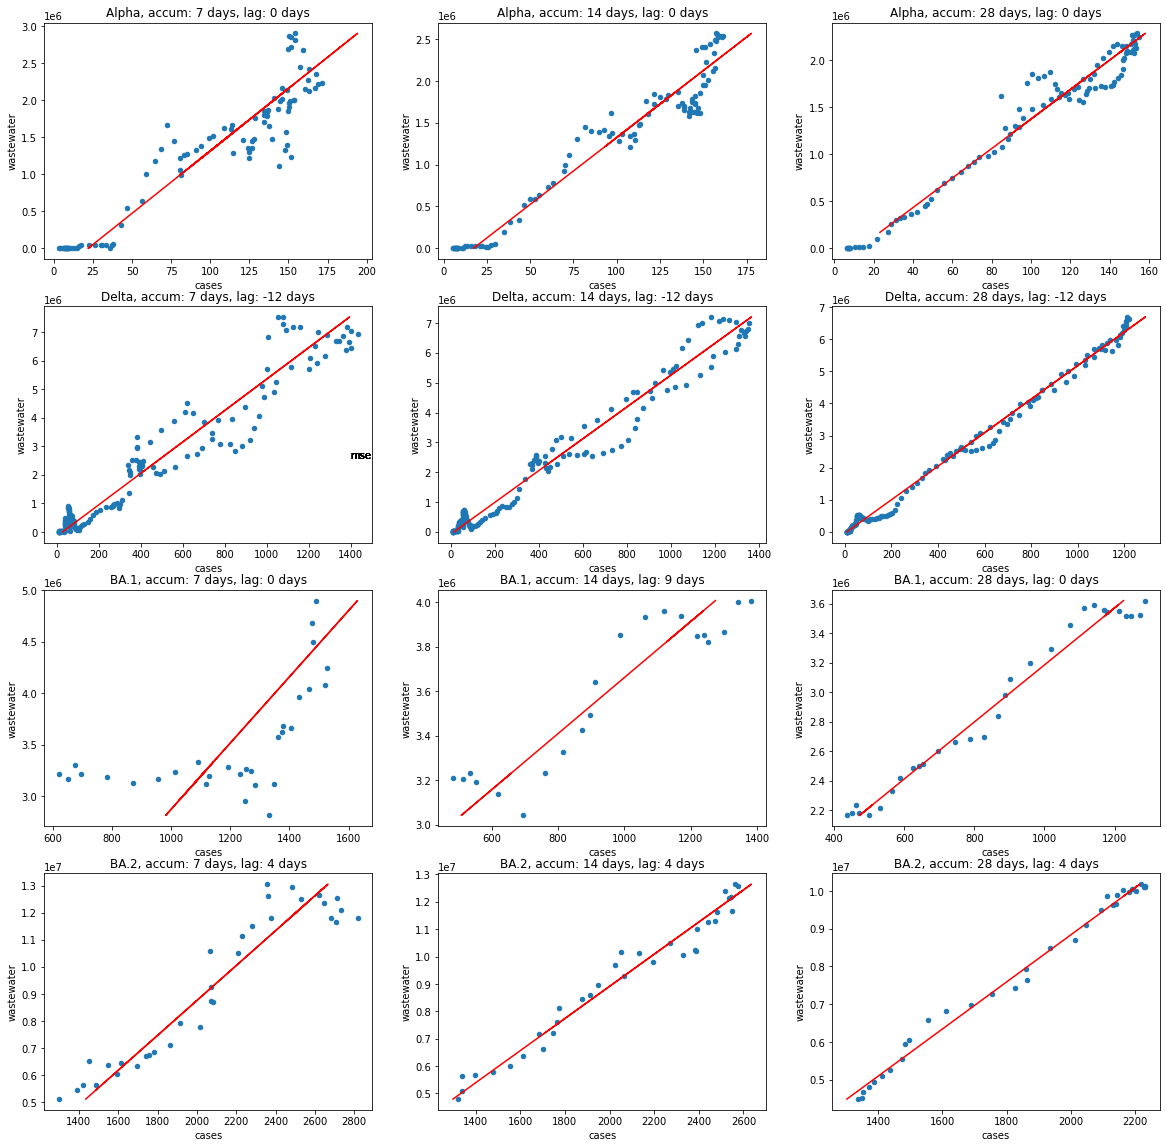

In [200]:
df_total = pd.DataFrame()
fig, ax = plt.subplots(
    len(variants), 3, figsize=(20, 5 * len(variants))  # , sharex=True, sharey=True
)
ci = {}
for w, v in enumerate(variants.keys()):
    df_shifted = df.loc[variants[v]].copy()
    ci[v] = {}
    for i, k in enumerate((7, 14, 28)):
        df_shifted, lag = shift(df_shifted, k)
        df_shifted.plot.scatter(
            f"rki_{k}days",
            f"sum_{k}days",
            title=f"{v}, accum: {k} days, lag: {lag} days",
            ax=ax[w, i],
            ylabel="wastewater",
            xlabel="cases",
        )
        df_tmp = df_shifted.filter((f"rki_{k}days", f"sum_{k}days")).dropna()
        df_shifted[f"pred_{k}"] = get_lin_model(
            df_tmp[f"sum_{k}days"], df_tmp[f"rki_{k}days"], v
        )
        ci[v][k] = get_lin_coeff(df_tmp[f"sum_{k}days"], df_tmp[f"rki_{k}days"], v)
        df_shifted.plot.line(
            f"pred_{k}",
            f"sum_{k}days",
            ax=ax[w, i],
            legend=False,
            color="r",
            ylabel="wastewater",
            xlabel="cases",
        )
        mse = (df_shifted[f"pred_{k}"] - df_shifted[f"rki_{k}days"]).pow(2).mean()
        plt.annotate("mse", (0.3, 0.6), xycoords="subfigure fraction")
    # df_shifted["sumavg"] = df_shifted.filter(regex="sum").mean(axis=1, skipna=False)
    # df_shifted["rkiavg"] = df_shifted.filter(regex="rki").mean(axis=1, skipna=False)
    # df_tmp = df_shifted.filter((f"rkiavg", f"sumavg")).dropna()
    # df_shifted["predavg"] = get_lin_model(df_tmp["sumavg"], df_tmp["rkiavg"], v)
    df_total = pd.concat([df_total, df_shifted.copy()])

    # coeffs
    # ci[v] = get_lin_coeff(df_tmp["sumavg"], df_tmp["rkiavg"], v)
    # # plotting avg
    # for i, k in enumerate((7, 14, 28)):
    #     df_shifted.plot.line(
    #         "predavg",
    #         "sumavg",
    #         style="--",
    #         ax=ax[w, i],
    #         color="r",
    #         ylabel="wastewater",
    #         xlabel="cases",
    #         legend=False,
    #     )

plt.tight_layout()
plt.savefig("correlation.png")
plt.show()


<AxesSubplot:xlabel='pred_28', ylabel='sum_28days'>

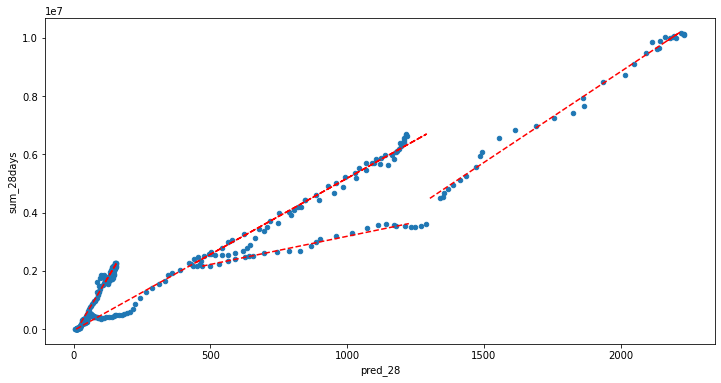

In [172]:
k = 28
ax = df_total.plot.scatter(f"rki_{k}days", f"sum_{k}days", figsize=(12, 6))
df_total.plot.line(f"pred_{k}", f"sum_{k}days", ax=ax, color="r", style="--", legend=False)


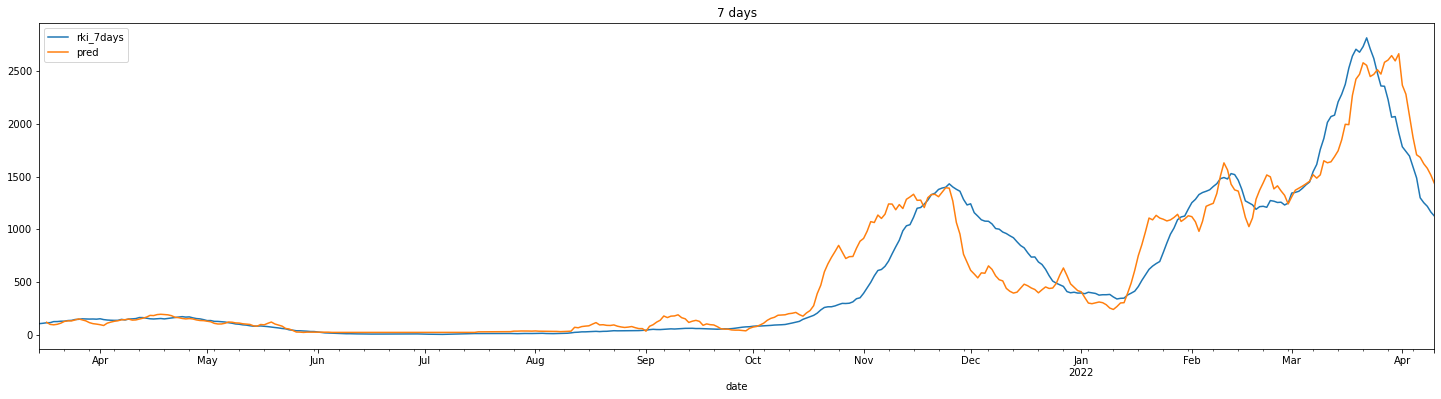

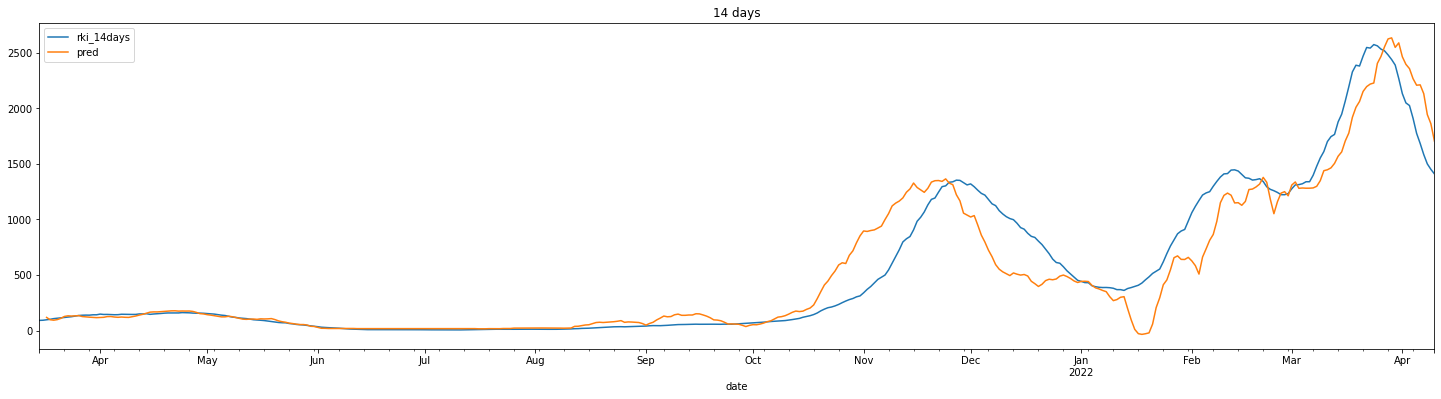

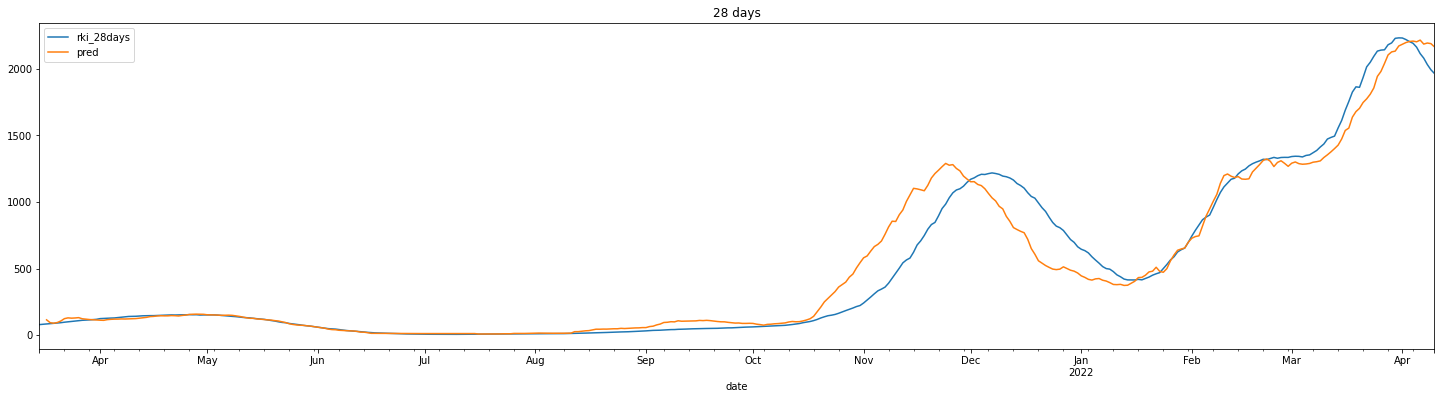

In [183]:
# total prediction
for k in (7, 14, 28):
    df_pred = df.filter(regex=f"{k}days").copy()
    for v in ci:
        df_pred.loc[variants[v] > 0.5, "c"] = ci[v][k][0]
        df_pred.loc[variants[v] > 0.5, "i"] = ci[v][k][1]
    df_pred.interpolate("time", axis=0, inplace=True)
    df_pred["pred"] = df_pred[f"sum_{k}days"] * df_pred["c"] + df_pred["i"]
    df_pred.filter(regex=f"rki_{k}|pred").plot(figsize=(25, 6), title=f"{k} days")
plt.show()

In [122]:
px.line(df_total.filter(regex="rki|pred").resample("1D").sum())

In [127]:
# errors
for k in (7, 14, 28):
    print(f'{k:3}: {(df_total[f"rki_{k}days"] - df_total[f"pred_{k}"]).pow(2).mean():5.0f}')
print(f'avg: {(df_total[f"rkiavg"] - df_total[f"predavg"]).pow(2).mean():5.0f}')

  7: 12995
 14:  4255
 28:   896
avg:  3247
